In [14]:
# -- Packages
import numpy as np
import pandas as pd 
import os


# -- Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [15]:
df = pd.read_csv('BID_Historical_Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,3/27/2024,52500.0,53300.0,55100.0,52500.0,1.61M,-1.13%
1,3/26/2024,53100.0,53000.0,54000.0,53000.0,1.21M,0.19%
2,3/25/2024,53000.0,54200.0,55400.0,52600.0,1.26M,-2.21%
3,3/22/2024,54200.0,53000.0,56700.0,53000.0,4.36M,2.26%
4,3/21/2024,53000.0,53200.0,53400.0,52800.0,1.86M,0.00%


In [16]:
df.drop(columns=['Open','High','Low','Vol.','Change %'],inplace=True)
df.head()

,Date,Price
0,3/27/2024,52500.0
1,3/26/2024,53100.0
2,3/25/2024,53000.0
3,3/22/2024,54200.0
4,3/21/2024,53000.0


In [47]:
df["Date"] = pd.to_datetime(df["Date"]).dt.to_period('D')

In [55]:
df = df.set_index(['Date']).sort_index()

In [56]:

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

def integrate_series(series, order):
    integrated_series = series.copy()
    for i in range(order):
        integrated_series = integrated_series.diff().dropna()
    return integrated_series

In [57]:
df['Price'] = df['Price'].astype(float) 

<Axes: xlabel='Date'>

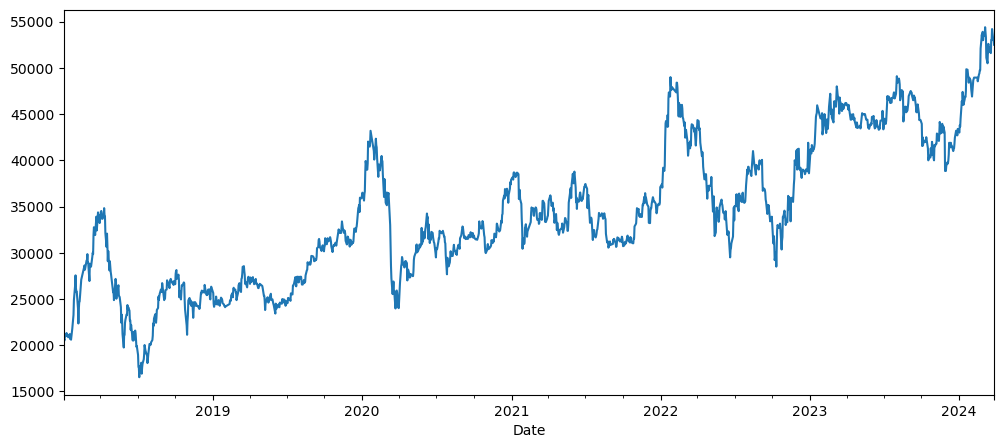

In [59]:

df['Price'].plot(figsize=(12,5))

In [60]:
check_stationarity(df['Price'])

ADF Statistic: -1.627988
p-value: 0.468544
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Non-stationary


In [61]:
# Sử dụng hàm để tích hợp sai phân bậc k
dfGas = df['Price']
BID_stationary = integrate_series(dfGas, 2)  # Ví dụ tích hợp sai phân bậc 2

# Kiểm tra tính dừng của dữ liệu sau khi tích hợp sai phân
check_stationarity(BID_stationary)

ADF Statistic: -14.812080
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


In [62]:
train_data = BID_stationary[:int(0.8*len(BID_stationary))]
test_data = BID_stationary[int(0.8*len(BID_stationary)):]

In [63]:
BID_stationary.head()

Date
2018-01-04    727.1
2018-01-05   -688.8
2018-01-08    459.2
2018-01-09   -688.8
2018-01-10    382.7
Freq: D, Name: Price, dtype: float64

In [64]:
fourier = CalendarFourier(freq='M',order=4)
dp = DeterministicProcess(
    index=train_data.index, constant=True, order=2, seasonal=False, additional_terms=[fourier], drop=True
)
X = dp.in_sample()

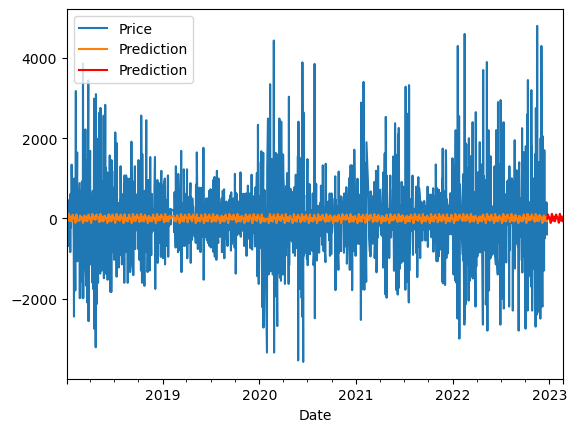

In [66]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X,train_data)
predictions = pd.DataFrame(
                    model.predict(X),
                    index=X.index,
                    columns=['Prediction']
)
X_out = dp.out_of_sample(60)
predictions_out = pd.DataFrame(
                        model.predict(X_out),
                        index=X_out.index,
                        columns=['Prediction']
)
plt.figure()
ax = plt.subplot()
train_data.plot(ax=ax, legend=True)
predictions.plot(ax=ax)
predictions_out.plot(ax=ax, color='red')
plt.show()